In [1]:
"Based on the fp_transition_matrix in 2nd step, single cell trajectories are simulated with the transition matrix. "

'Based on the fp_transition_matrix in 2nd step, single cell trajectories are simulated with the transition matrix. '

In [3]:
import scvelo as scv
import pandas as pd 
import numpy as np
from anndata import AnnData
import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.patches as mpatches
import pickle
import os
import leidenalg
from scipy import sparse
from IPython.display import SVG
from sklearn.linear_model import LinearRegression
from scipy import stats,signal
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from filter_dispersion import filter_dispersion
from scipy.sparse import issparse
from scvelo.preprocessing.utils import get_mean_var,materialize_as_ndarray

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
result_path='result/'
adata=scv.read(result_path+'EG_dyn.h5ad')
adata.uns['velocity_graph']=adata.obsp['fp_transition_matrix']
t_list=['Ngn3 low EP','Ngn3 high EP','Fev+','Alpha']

In [6]:
"transition matrix of single cell"

'transition matrix of single cell'

In [7]:
T=adata.obsp['fp_transition_matrix']

In [8]:
source_mean=np.mean(adata[(adata.obs['clusters']==t_list[0]),:].obsm['X_pca'],axis=0)
target_mean=np.mean(adata[(adata.obs['clusters']==t_list[-1]),:].obsm['X_pca'],axis=0)
snodes=np.argsort(np.linalg.norm(adata.obsm['X_pca']-source_mean,axis=1))[:100]
tnodes=np.argsort(np.linalg.norm(adata.obsm['X_pca']-target_mean,axis=1))[:10]

In [9]:
def consecutive_arrs(data, stepsize=1):
    return np.split(data, np.where(np.diff(data)>stepsize)[0]+1)

In [13]:
#----adapted from scvelo----------
def get_cell_transitions(
    
    adata,
    T=T,
    starting_cell=0,
    basis=None,
    n_steps=100,
    n_neighbors=30,
    backward=False,
    random_state=None,
    **kwargs,
):
    """Simulate cell transitions
    Arguments
    ---------
    adata: :class:`~anndata.AnnData`
        Annotated data matrix.
    starting_cell: `int` (default: `0`)
        Index (`int`) or name (`obs_names) of starting cell.
    n_steps: `int` (default: `100`)
        Number of transitions/steps to be simulated.
    backward: `bool` (default: `False`)
        Whether to use the transition matrix to
        push forward (`False`) or to pull backward (`True`)
    random_state: `int` or `None` (default: `None`)
        Set to `int` for reproducibility, otherwise `None` for a random seed.
    **kwargs:
        To be passed to tl.transition_matrix.
    Returns
    -------
    Returns embedding coordinates (if basis is specified),
    otherwise return indices of simulated cell transitions.
    """

    np.random.seed(random_state)
    if isinstance(starting_cell, str) and starting_cell in adata.obs_names:
        starting_cell = adata.obs_names.get_loc(starting_cell)
    X = [starting_cell]
    for _ in range(n_steps):
        t = T[X[-1]]
        indices, p = t.indices, t.data
        if n_neighbors is not None and n_neighbors < len(p):
            idx = np.argsort(t.data)[::-1][:n_neighbors]
            indices, p = indices[idx], p[idx]
        if len(p) == 0:
            indices, p = [X[-1]], [1]
        p /= np.sum(p)
        ix = np.random.choice(indices, p=p)
        X.append(ix)
    X = pd.unique(X)
    if basis is not None and f"X_{basis}" in adata.obsm.keys():
        X = adata.obsm[f"X_{basis}"][X].T
    if backward:
        X = np.flip(X, axis=-1)
    return X

In [11]:
dwell_thres=10
traj_arrs=[]
traj_seri=[]
adata_arrs=[]
for sn in snodes:
    traj_ind=get_cell_transitions(adata, starting_cell=sn, n_steps=600)
    traj_t=np.array(adata[traj_ind,:].obs['clusters'].values)
    if len(np.where(traj_t==t_list[-1])[0])>0:
        F_arrs=consecutive_arrs(np.where(traj_t==t_list[-1])[0])
        
        end_t=0
        n=len(F_arrs)
        while n>=1:
            if F_arrs[n-1].shape[0]>dwell_thres:
                end_t=F_arrs[n-1][-1]
                break
            n-=1

        if end_t>0:
            traj_seri.append(traj_ind[:end_t])

            traj=np.array(adata[traj_ind[:end_t],:].obsm['X_pca'])
            traj_arrs.append(traj)
            adata_traj=adata[traj_ind[:end_t],:]
            adata_arrs.append(adata_traj)

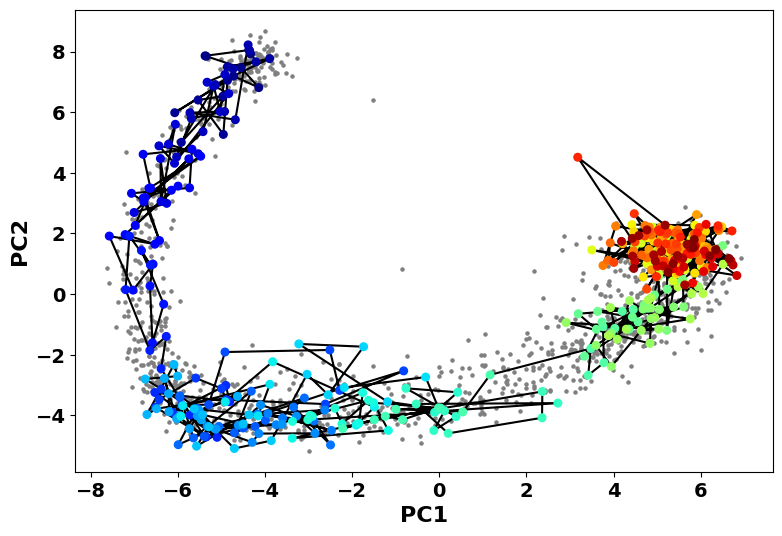

In [12]:
fig,ax=plt.subplots(figsize=(9,6))

# plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=np.unique(adata.obs['sample'], return_inverse=True)[1],cmap='jet')
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,color='grey')

color_arr=['black']
for i in range(1):#(len(traj_arrs)):
    
    plt.plot(-traj_arrs[i][:,0],traj_arrs[i][:,1],color=color_arr[i])
    dot_color=np.arange(traj_arrs[i].shape[0])
    
    plt.scatter(-traj_arrs[i][:,0],traj_arrs[i][:,1],s=30,c=dot_color,cmap=plt.cm.jet,zorder=10)
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'EG_traj.png',dpi=300)
plt.show()

In [10]:
if not os.path.exists('result/EG_dyn_traj'):
    os.makedirs('result/EG_dyn_traj')
for i in range(len(traj_arrs)):
#       np.save('result/emt_dyn_traj/'+str(i)+'.npy',traj_arrs[i])
    adata_arrs[i].write(filename='result/EG_dyn_traj/'+str(i)+'.h5ad')